# Machine Learning Race Predictor
## Supervised Learning - Regression

## Data Preparation:

First we load the raw data that was gathered from thousands of users' public training logs. These contained training data as well as race results.

In [69]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames
import datetime
import time

pd.set_option('display.max_rows', 500)

# Pretty display for notebooks
%matplotlib inline

pd.set_option('display.max_columns', 500)

# Load all the running data
try:
    all_data = pd.read_csv("marathonData.csv")
    print "Running dataset has {} samples with {} features each.".format(*all_data.shape)
except:
    print "Dataset could not be loaded. Is the dataset missing?"
    
#We'll be predicting both marathon and half marathons that need different features so we need to
#split the data up
data = {}
data['half'] = all_data[[
        '5K','10K','half','halfTrainDis12',
        'halfTrainDis3','halfTrainPaceSec12',
        'halfTrainDays12']]

data['marathon'] = all_data[[
        '5K','10K','half','marathon','marathonTrainDis12',
        'marathonTrainDis3','marathonTrainPaceSec12',
        'marathonTrainDays12']]

for race, race_data in data.iteritems():
    print race, 'initial rows and features:', race_data.shape
    race_data = race_data.dropna()
    print race, 'after dropping NA', race_data.shape

display(data['marathon'].head())
display(data['marathon'].describe())

Running dataset has 4688 samples with 54 features each.
marathon initial rows and features: (4688, 8)
marathon after dropping NA (4223, 8)
half initial rows and features: (4688, 7)
half after dropping NA (4234, 7)


,5K,10K,half,marathon,marathonTrainDis12,marathonTrainDis3,marathonTrainPaceSec12,marathonTrainDays12
0,24:31,54:14,2:20:12,5:42:35,22.182961,38.215652,646.399640,55
1,21:27,43:21,1:34:11,3:20:10,27.019282,108.077129,519.261585,35
2,22:23,48:20,1:47:42,6:30:24,0.000000,0.000000,0.000000,0
3,20:50,44:07,1:49:58,5:33:12,0.000000,0.000000,0.000000,0
4,20:43,43:41,1:41:57,4:55:53,0.000000,0.000000,0.000000,0


,marathonTrainDis12,marathonTrainDis3,marathonTrainPaceSec12,marathonTrainDays12
count,4688.000000,4688.000000,4647.000000,4688.000000
mean,32.853701,49.477672,289.620072,63.114761
std,47.839787,64.851282,304.483238,92.141511
min,0.000000,0.000000,-3648.395891,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.154848,0.000000,404.914605,1.000000
75%,55.354000,93.653066,551.189334,110.000000
max,318.739408,454.763512,1391.925545,610.000000


In [56]:
#utility functions to deal with time and riegel formula for later use
import math
from __future__ import division

fivek_dis = 5000 #5K in meters
tenk_dis = 10000 #10K in meters
half_dis = 21097 #Half marathon in meters
marathon_dis = 42195 #Marathon in meters

def riegel(t1, d1=fivek_dis, d2=marathon_dis):
    return t1 * math.pow((d2/d1),1.06)

def secondsToTime(seconds):
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)
    return "%d:%02d:%02d" % (h, m, s)

def timeToSeconds(t):
    try:
        t = t.split('.')[0]
    except:
        return 0
    try:
        x = time.strptime(t,'%H:%M:%S')
        return datetime.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds()
    except:
        x = time.strptime(t,'%M:%S')
        return datetime.timedelta(minutes=x.tm_min,seconds=x.tm_sec).total_seconds()

for race in data:
    data[race] = data[race].replace(0,np.nan).dropna()
    data[race] = data[race].replace('null',np.nan).dropna()

    data[race].reset_index(drop=True, inplace=True)

    print race,'after removing data with no running activities', data[race].shape
    
    for race_distance in ['5K','10K','half']:
        data[race][race_distance] = data[race][race_distance].map(lambda x: timeToSeconds(x))

    if race == 'marathon':
        data[race]['marathon'] = data[race]['marathon'].map(lambda x: timeToSeconds(x))

display(data['marathon'].sample(10))
display(data['marathon'].describe())

marathon after removing data with no running activities (2116, 8)
half after removing data with no running activities (1807, 7)


,5K,10K,half,marathon,marathonTrainDis12,marathonTrainDis3,marathonTrainPaceSec12,marathonTrainDays12
1748,1537.0,3177.0,7365.0,20142.0,17.534712,70.138850,579.150957,32.0
1333,1494.0,3092.0,7030.0,14425.0,15.494418,61.977672,562.258023,28.0
1674,1155.0,2336.0,5115.0,11335.0,171.063929,216.995644,482.026446,277.0
2001,1300.0,2900.0,6605.0,14018.0,40.233903,125.486564,545.252039,57.0
1089,1282.0,2665.0,6132.0,13399.0,75.852543,113.860892,517.914699,173.0
1370,1159.0,2395.0,5182.0,11244.0,130.011910,124.965937,443.162728,208.0
222,332.0,1658.0,4790.0,14296.0,60.827238,80.222142,563.338068,105.0
1167,1286.0,2584.0,5689.0,13126.0,31.411735,73.671132,535.374115,65.0
517,1489.0,3141.0,6906.0,16697.0,38.210158,44.953739,612.979655,70.0
44,1149.0,2319.0,5306.0,10733.0,146.173099,172.195318,550.220417,180.0


,5K,10K,half,marathon,marathonTrainDis12,marathonTrainDis3,marathonTrainPaceSec12,marathonTrainDays12
count,2116.000000,2116.000000,2116.000000,2116.000000,2116.000000,2116.000000,2116.000000,2116.000000
mean,1306.372401,2780.177221,6333.254253,14567.525992,66.990378,101.014370,574.568802,129.566635
std,246.813873,496.651589,1219.089498,3220.702839,49.212269,57.759650,145.661882,95.677392
min,0.000000,132.000000,1693.000000,8163.000000,0.084685,0.338739,-3648.395891,1.000000
25%,1163.000000,2457.000000,5492.000000,12348.750000,29.531741,60.867387,501.386530,55.000000
50%,1286.000000,2718.500000,6115.500000,13956.500000,56.499229,95.170347,552.341724,113.000000
75%,1433.250000,3045.000000,6911.250000,16271.250000,92.022014,132.801645,627.372137,180.000000
max,2460.000000,5129.000000,14379.000000,34985.000000,318.739408,410.232163,1391.925545,610.000000


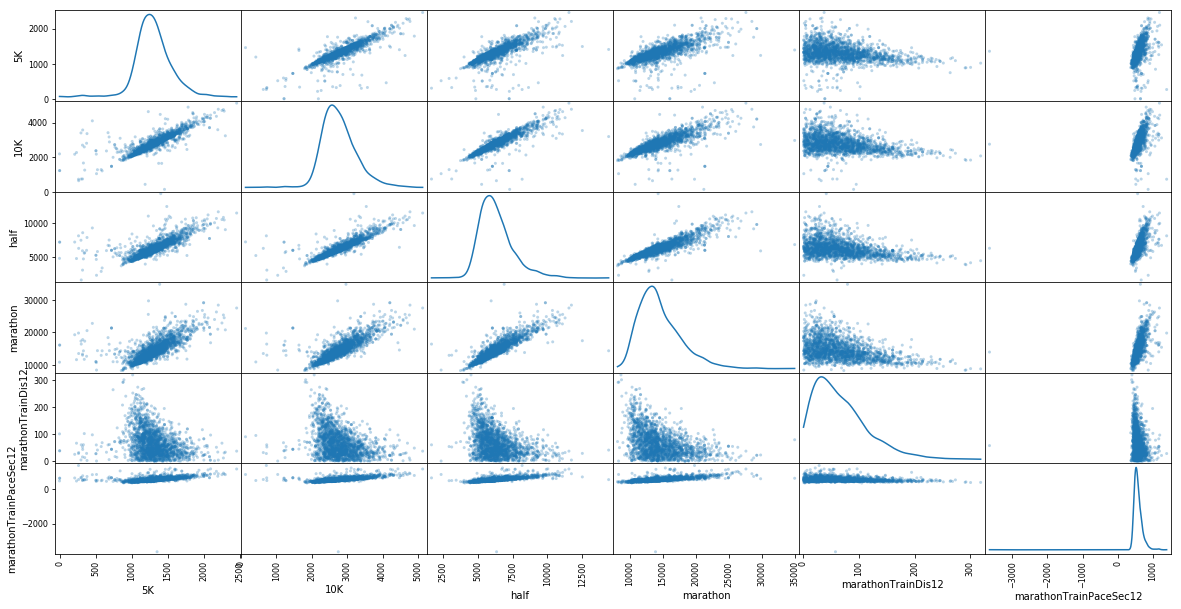

In [57]:
# Produce a scatter matrix for each pair of features in the data
pd.plotting.scatter_matrix(data['marathon'][[
    '5K','10K','half','marathon','marathonTrainDis12','marathonTrainPaceSec12']], alpha = 0.3, figsize = (20,10), diagonal = 'kde');

In [58]:
# before removing general outliers, remove other nonsense data.
for race in data:
    # remove 5K times that are below the world record haha
    data[race] = data[race].loc[data[race]['5K'] > timeToSeconds('12:37')]

    # remove 5K times that are below the world record haha
    data[race] = data[race].loc[data[race]['10K'] > timeToSeconds('12:37')]

    # same for half times
    data[race] = data[race].loc[data[race]['half'] > timeToSeconds('58:23')]

    # same for marathon times
    if race == 'marathon':
        data[race] = data[race].loc[data[race]['marathon'] > timeToSeconds('2:02:57')]

        # remove anyone running less than 10 miles a month for the past 12 months to prepare for a marathon as this most likely means they are not
        # tracking all their data from the garmin connect site.
        data[race] = data[race].loc[data[race][race + 'TrainDis12'] > 15]

        # remove anyone running less than 40 miles a month in the last 3 months to prepare for a marathon as this most likely means they are not
        # tracking all their data from the garmin connect site.
        data[race] = data[race].loc[data[race][race + 'TrainDis3'] > 60]
    else:
         # remove anyone running less than 10 miles a month for the past 12 months to prepare for a marathon as this most likely means they are not
        # tracking all their data from the garmin connect site.
        data[race] = data[race].loc[data[race][race + 'TrainDis12'] > 10]

        # remove anyone running less than 40 miles a month in the last 3 months to prepare for a marathon as this most likely means they are not
        # tracking all their data from the garmin connect site.
        data[race] = data[race].loc[data[race][race + 'TrainDis3'] > 40]

    # no one is averaging under 5 minute pace for all of training
    data[race] = data[race].loc[data[race][race + 'TrainPaceSec12'] > 300]
    
    print race,'after removing nonsense', data[race].shape
    
display(data['marathon'].describe())

marathon after removing nonsense (1583, 8)
half after removing nonsense (1422, 7)


,5K,10K,half,marathon,marathonTrainDis12,marathonTrainDis3,marathonTrainPaceSec12,marathonTrainDays12
count,1583.000000,1583.000000,1583.000000,1583.000000,1583.000000,1583.000000,1583.000000,1583.000000
mean,1292.852179,2731.954517,6177.567277,14017.553380,81.185231,122.722311,563.285125,155.996210
std,205.849858,439.454420,1101.688485,2824.603787,47.542219,48.750694,102.390463,92.961909
min,766.000000,1637.000000,3772.000000,8163.000000,15.009869,60.039476,367.944949,21.000000
25%,1155.000000,2423.500000,5399.000000,11982.500000,45.401973,86.797743,495.868597,87.000000
50%,1268.000000,2665.000000,5987.000000,13601.000000,72.711123,111.401452,542.456588,141.000000
75%,1399.500000,2964.500000,6720.500000,15471.500000,105.611229,146.647513,605.110575,203.000000
max,2460.000000,5129.000000,14379.000000,34985.000000,318.739408,410.232163,1246.180502,610.000000


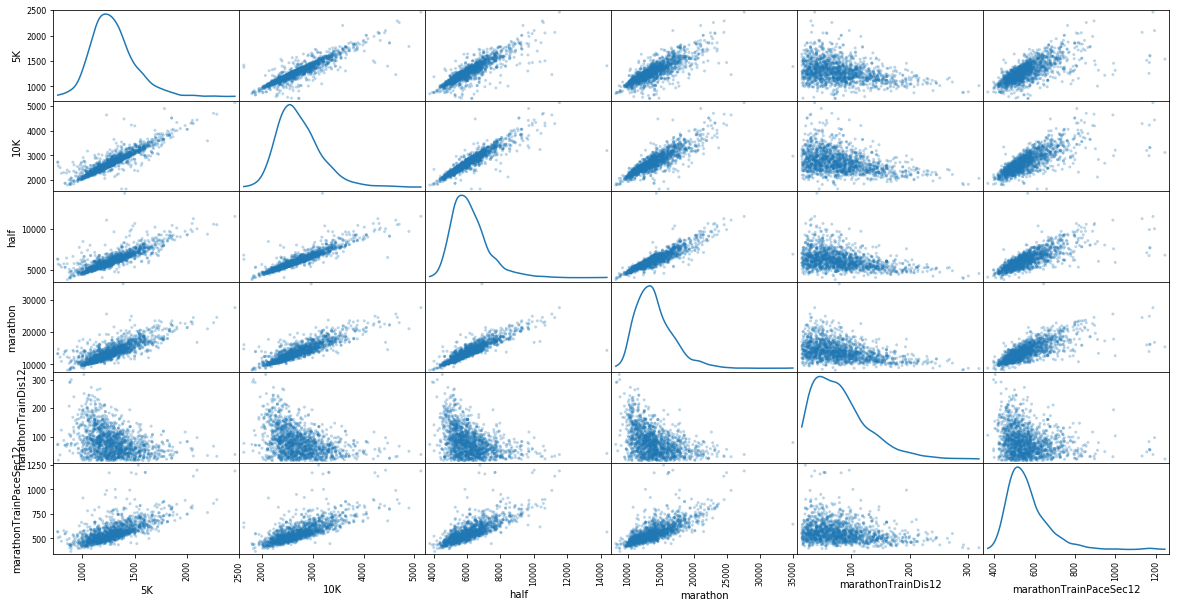

In [59]:
# Produce a scatter matrix for each pair of features in the data
pd.plotting.scatter_matrix(data['marathon'][[
    '5K','10K','half','marathon','marathonTrainDis12','marathonTrainPaceSec12']], alpha = 0.3, figsize = (20,10), diagonal = 'kde');

In [60]:
# Removing outliers
# remove anyone who's times are totally out of whack. If you ran a sub 3 hour marathon and then ran a
# 5K over 25 minutes, it's probably not an actual race, or maybe they ran with a friend or something. So even though
# on their own, these aren't outliers, they are compared to each other.
# Going to use a simple linear regression with every combo to find the outliers
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from itertools import combinations

np.set_printoptions(threshold=np.nan)

for race in data:

    outlier_detector = EllipticEnvelope(contamination=.2).fit(data[race])
    #outlier_detector = IsolationForest(contamination=.25).fit(data[race])

    half_outliers = data[race][outlier_detector.predict(data[race])==-1]
    data[race] = data[race][outlier_detector.predict(data[race])==1]

    #display(half_outliers.sample(10))
    #display(data[race].sample(10))

    print race,'after removing outliers', data[race].shape
    
display(data['marathon'].describe())


marathon after removing outliers (1266, 8)
half after removing outliers (1137, 7)


,5K,10K,half,marathon,marathonTrainDis12,marathonTrainDis3,marathonTrainPaceSec12,marathonTrainDays12
count,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000
mean,1284.041074,2699.319115,6054.695103,13727.609005,77.691522,118.495870,544.507976,141.750395
std,172.651359,367.316825,882.490368,2377.329600,42.780381,41.527560,71.004983,73.777076
min,858.000000,1797.000000,3772.000000,8163.000000,15.494418,60.197433,367.944949,21.000000
25%,1163.000000,2436.000000,5399.000000,11971.000000,43.704340,86.524944,491.928611,85.000000
50%,1263.500000,2646.000000,5950.500000,13423.500000,70.786192,110.472920,533.946139,133.000000
75%,1380.000000,2929.000000,6587.000000,15152.500000,102.248277,141.797042,582.637460,189.000000
max,1906.000000,4054.000000,9294.000000,21945.000000,240.070732,274.277477,837.012925,414.000000


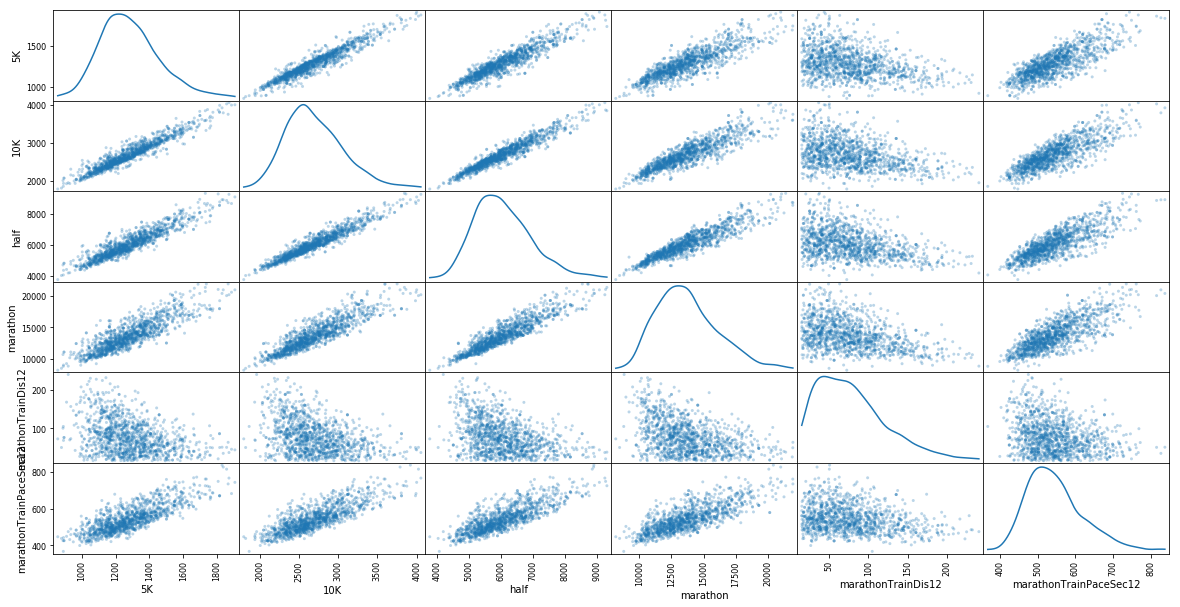

In [61]:
# Produce a scatter matrix for each pair of features in the data
pd.plotting.scatter_matrix(data['marathon'][[
    '5K','10K','half','marathon','marathonTrainDis12','marathonTrainPaceSec12']], alpha = 0.3, figsize = (20,10), diagonal = 'kde');

In [62]:
# Split the data into features and target label
y = {}
x = {}
for race in data:
    y[race] = data[race][race]
    x[race] = data[race].drop(race, axis = 1)

In [63]:
# Import train_test_split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = {},{},{},{}

for race in data:
    # Split the 'features' and 'income' data into training and testing sets
    X_train[race], X_test[race], y_train[race], y_test[race] = train_test_split(
        x[race], y[race], test_size = 0.2, random_state = 42)

    # Show the results of the split
    print race, "training set has {} samples.".format(X_train[race].shape[0])
    print race, "testing set has {} samples.".format(X_test[race].shape[0])

marathon training set has 1012 samples.
marathon testing set has 254 samples.
half training set has 909 samples.
half testing set has 228 samples.


In [64]:
## Using Reigel (the old runner's world formula) as a benchmark
from sklearn.metrics import r2_score

compare = None

def printResults(x, y_true, y_pred, race, verbose=False):
    global compare
    
    x.reset_index(drop=True, inplace=True)
    y_true.reset_index(drop=True, inplace=True)
    y_pred.reset_index(drop=True, inplace=True)
    
    
    compare = pd.concat([x, y_pred, y_true], axis=1)
    
    last_column = len(compare.columns) - 1
    compare.columns.values[last_column] = 'true'
    compare.columns.values[last_column-1] = 'pred'
    percent_off = abs(100 * (compare['pred'] - compare['true'])/compare['true'])
    
    if race == 'half':
        compare = compare.sort_values(by=['10K'])
    else:
        compare = compare.sort_values(by=['half'])

    if verbose:
        print 'Average percent off {0:.2f}%'.format(percent_off.mean())
    #print 'Average actual marathon time {}'.format(secondsToTime(compare['marathon_true'].mean()))
    #print 'Average predicted marathon time {}'.format(secondsToTime(compare['marathon_pred'].mean()))
    percent_off_formatted = percent_off.map(lambda x: "{0:.2f}%".format(x))

    if verbose:
        print 'Coefficient of Determination (R2): ', r2_score(compare['true'], compare['pred'])
    
        #display(compare)
    if race == 'half':                                                                          
        for feature in ['5K','10K',race+'TrainPaceSec12','true','pred']:
            compare[feature] = compare[feature].map(lambda x: secondsToTime(x))
    else:
        for feature in ['5K','10K','half',race+'TrainPaceSec12','true','pred']:
            compare[feature] = compare[feature].map(lambda x: secondsToTime(x))
                                                                                   
    for feature in [race+'TrainDis12',race+'TrainDis3',race+'TrainDays12']:
        compare[feature] = compare[feature].map(lambda x: "{0:.0f}".format(x)) 
                                                                                   
    compare = pd.concat([compare, percent_off_formatted], axis=1)
    compare.columns.values[last_column+1] = 'percent_off'
    
    if verbose:
        length = len(compare.index)
        indices = [0,int(length/4),int(length/2),int(length*3/4),length-1]

        # Create a DataFrame of the chosen samples
        samples = pd.DataFrame(compare.loc[indices])
        display(samples)
        #display(compare.head(6))
    
#Use riegel to predict half based on 5K
print 'riegel for half based on 5K:'
riegel_half = x['half']["5K"].map(lambda x: riegel(x, fivek_dis, half_dis))
printResults(x['half'], y['half'], riegel_half, 'half', True)

#Use riegel to predict marathon based on half
print 'riegel for marathon based on 5K:'
riegel_marathon_5K = x['marathon']["5K"].map(lambda x: riegel(x, fivek_dis, marathon_dis))
printResults(x['marathon'], y['marathon'], riegel_marathon_5K, 'marathon', True)

m_below = 0
m_count = 0
for i, m_pred in enumerate(riegel_marathon_5K):
    m_count += 1
    if (m_pred < y['marathon'][i]):
        m_below += 1
        
print 'Percent marathon from 5K preditions below actual result: {0:.2f}%'.format(100 * m_below/m_count)

#Use riegel to predict marathon based on half
print 'riegel for marathon based on half:'
riegel_marathon_half = x['marathon']["half"].map(lambda x: riegel(x, half_dis, marathon_dis))
printResults(x['marathon'], y['marathon'], riegel_marathon_half, 'marathon', True)

m_below = 0
m_count = 0
for i, m_pred in enumerate(riegel_marathon_half):
    m_count += 1
    if (m_pred < y['marathon'][i]):
        m_below += 1
        
print 'Percent marathon from half preditions below actual result: {0:.2f}%'.format(100 * m_below/m_count)
    


riegel for half based on 5K:
Average percent off 3.90%
Coefficient of Determination (R2):  0.859521934604


,5K,10K,halfTrainDis12,halfTrainDis3,halfTrainPaceSec12,halfTrainDays12,pred,true,percent_off
0,0:19:43,0:40:38,26,72,0:08:07,55,1:30:41,1:27:55,3.16%
284,0:26:51,0:55:41,93,92,0:11:44,120,2:03:30,2:01:32,1.63%
568,0:22:58,0:47:24,107,113,0:10:47,189,1:45:38,1:47:10,1.42%
852,0:22:03,0:46:19,34,68,0:09:57,76,1:41:25,1:41:50,0.39%
1136,0:20:43,0:46:24,41,83,0:08:26,89,1:35:17,1:40:20,5.02%


riegel for marathon based on 5K:
Average percent off 10.09%
Coefficient of Determination (R2):  0.356883579775


,5K,10K,half,marathonTrainDis12,marathonTrainDis3,marathonTrainPaceSec12,marathonTrainDays12,pred,true,percent_off
0,0:21:27,0:43:21,1:34:11,27,108,0:08:39,35,3:25:43,3:20:10,2.78%
316,0:19:19,0:39:54,1:27:25,38,134,0:10:29,44,3:05:16,3:14:21,4.67%
633,0:19:28,0:40:47,1:29:17,126,150,0:07:38,188,3:06:42,3:12:31,3.02%
949,0:19:05,0:39:48,1:27:57,19,70,0:10:07,30,3:03:01,3:33:56,14.45%
1265,0:20:43,0:46:24,1:40:20,57,95,0:08:27,121,3:18:41,3:30:07,5.44%


Percent marathon from 5K preditions below actual result: 89.73%
riegel for marathon based on half:
Average percent off 7.75%
Coefficient of Determination (R2):  0.609482078262


,5K,10K,half,marathonTrainDis12,marathonTrainDis3,marathonTrainPaceSec12,marathonTrainDays12,pred,true,percent_off
0,0:21:27,0:43:21,1:34:11,27,108,0:08:39,35,3:16:22,3:20:10,1.90%
316,0:19:19,0:39:54,1:27:25,38,134,0:10:29,44,3:02:15,3:14:21,6.22%
633,0:19:28,0:40:47,1:29:17,126,150,0:07:38,188,3:06:09,3:12:31,3.30%
949,0:19:05,0:39:48,1:27:57,19,70,0:10:07,30,3:03:22,3:33:56,14.28%
1265,0:20:43,0:46:24,1:40:20,57,95,0:08:27,121,3:29:11,3:30:07,0.44%


Percent marathon from half preditions below actual result: 91.00%


### Riegel's formula

As you can see from the chart below, the current age old formula is not very good at predicting marathon results from 5K times. Out of all the data points, very few are below the line, and the ones that are, are the elite, faster times. AS you move to the right, they get farther away from the line.

Without even providing any other features, it would already be easy to vastly improve on this formula from doing a simple linear regression on 5K alone. Let's do that and see!

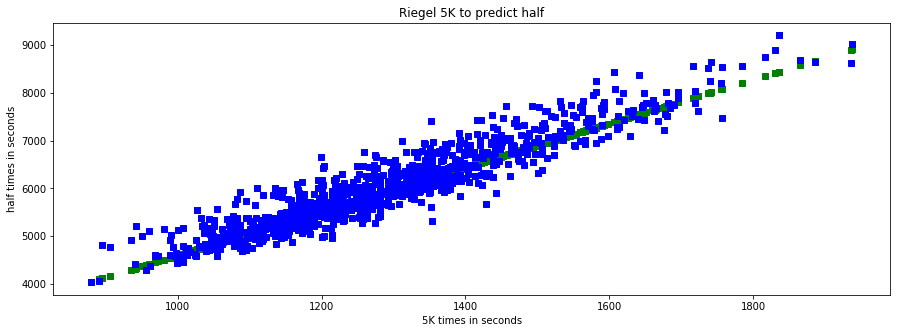

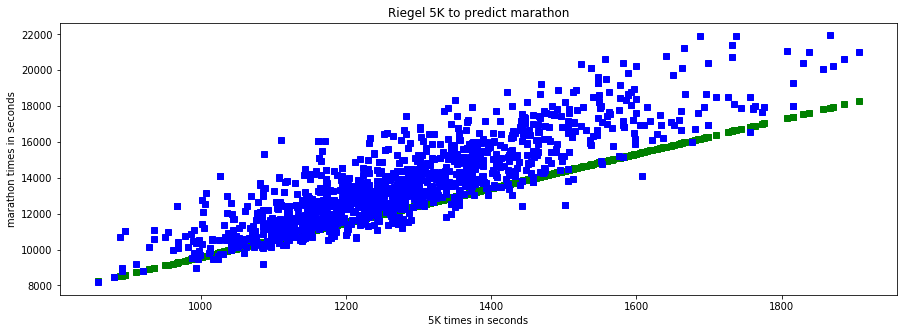

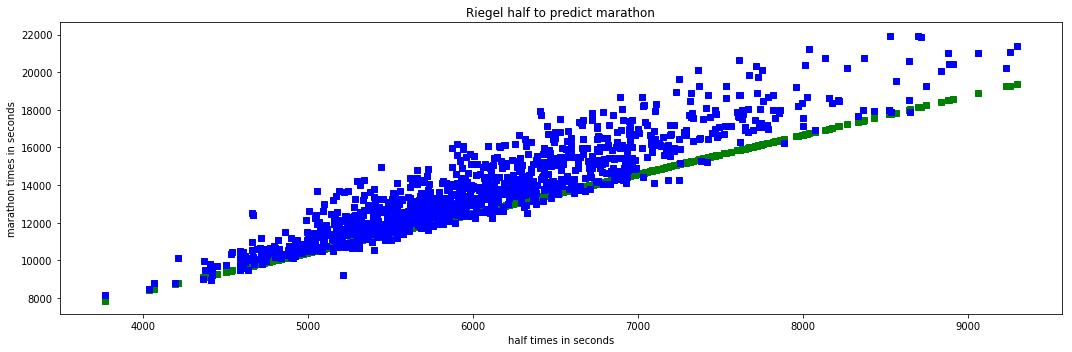

In [65]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.xlabel('5K times in seconds')
plt.ylabel('half times in seconds')
plt.title('Riegel 5K to predict half')
plt.plot(x['half']['5K'], riegel_half, 'gs', x['half']['5K'], y['half'], 'bs')

plt.figure(figsize=(15,5))
plt.xlabel('5K times in seconds')
plt.ylabel('marathon times in seconds')
plt.title('Riegel 5K to predict marathon')
plt.plot(x['marathon']['5K'], riegel_marathon_5K, 'gs', x['marathon']['5K'], y['marathon'], 'bs')

plt.figure(figsize=(15,5))
plt.xlabel('half times in seconds')
plt.ylabel('marathon times in seconds')
plt.title('Riegel half to predict marathon')
plt.plot(x['marathon']['half'], riegel_marathon_half, 'gs', x['marathon']['half'], y['marathon'], 'bs')

plt.tight_layout()
plt.show()

In [66]:
from sklearn.base import clone

reg_data = {'half':{}, 'marathon':{}}
best_regs = {'half': {}, 'marathon':{}}

def run_regressor(race, reg, verbose=True):
    feature_combo_ns = []
    reg_data[race]['best_r2'] = 0
    reg_data[race]['best_feature_combo'] = None
    reg_data[race]['best_percent_off'] = 0
    reg_data[race]['best_reg'] = None
    reg_data[race]['best_pred'] = None
    reg_data[race]['best_compare'] = None

    if race == 'marathon':
        for i in range(7):   
            feature_combo_ns.append(list(combinations([
                '5K','10K','half',race+'TrainDis12',race+'TrainDis3',race+'TrainPaceSec12',race+'TrainDays12'], i+1)))
    else:
        for i in range(6): 
            feature_combo_ns.append(list(combinations([
                '5K','10K',race+'TrainDis12',race+'TrainDis3',race+'TrainPaceSec12',race+'TrainDays12'], i+1)))

    #print feature_combo_ns

    for feature_combo_n in feature_combo_ns:
        for feature_combo in feature_combo_n:
            feature_combo_string = '|'.join(feature_combo)
            
            new_reg = clone(reg)
            #print feature_combo
            predicted = new_reg.fit(X_train[race][list(feature_combo)], y_train[race]).predict(
                X_test[race][list(feature_combo)])

            predicted = pd.Series(data = predicted)
            if verbose:
                printResults(X_test[race], y_test[race], predicted, race)
            r2 = r2_score(y_test[race], predicted)
            percent_off = abs(100 * (predicted - y_test[race])/y_test[race]).mean()
            
            #keeping track of best reg by feature combo
            f_combo_dict = {
                'reg': new_reg,
                'r2': r2,
                'percent_off': percent_off
            }
            
            if feature_combo_string in best_regs[race]:
                if r2 > best_regs[race]['r2']:
                    best_regs[race][feature_combo_string] = f_combo_dict
            else:
                best_regs[race][feature_combo_string] = f_combo_dict
            
            #print 'best r2 so far: ', reg_data[race]['best_r2']
            if r2 > reg_data[race]['best_r2']:
                reg_data[race]['best_r2'] = r2
                reg_data[race]['best_feature_combo'] = '|'.join(feature_combo)
                reg_data[race]['best_percent_off'] = percent_off
                reg_data[race]['best_reg'] = new_reg
                reg_data[race]['best_pred'] = predicted
                reg_data[race]['best_compare'] = compare
            #print '-----'
            
    print 'best feature combo: ', reg_data[race]['best_feature_combo']
    print 'R2: {0:.3f}'.format(reg_data[race]['best_r2'])
    print 'percent off: {0:.2f}%'.format(reg_data[race]['best_percent_off'])
        

In [67]:
# trying out a bunch of supervised learning regressors
import ipdb

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor

for race in best_regs:
    best_regs[race]['r2'] = 0
    best_regs[race]['reg'] = None
    best_regs[race]['pred'] = None
    best_regs[race]['compare'] = None
    best_regs[race]['feature_combo'] = None
    best_regs[race]['percent_off'] = 0

def run_lots_o_regressors():
    global best_r2
    global best_reg
    global best_predicted
    global best_compare
    global best_feature_combo
    regressors = [LinearRegression(),
                  GradientBoostingRegressor(),
                  Ridge(),
                  Lasso(),
                  KNeighborsRegressor()
                 ]

    for race in data:
        for reg in regressors:
            #for debugging uncomment below
            #ipdb.set_trace()
            print '----', reg ,'----'
            run_regressor(race, reg)
            #print 'best r2 for' ,reg, reg_data[race]['best_r2']
            if reg_data[race]['best_r2'] > best_regs[race]['r2']:
                best_regs[race]['r2'] = reg_data[race]['best_r2']
                best_regs[race]['feature_combo'] = reg_data[race]['best_feature_combo']
                best_regs[race]['percent_off'] = reg_data[race]['best_percent_off']
                best_regs[race]['reg'] = reg_data[race]['best_reg']
                best_regs[race]['pred'] = reg_data[race]['best_pred']
                best_regs[race]['compare'] = reg_data[race]['best_compare']

        print 'best overall -----'
        print 'best feature combo: ', best_regs[race]['feature_combo']
        print 'best reg: ', best_regs[race]['reg']
        print 'best percent off: ', best_regs[race]['percent_off']
        print 'best r2: ', best_regs[race]['r2']

        display(best_regs[race]['compare'].sample(20))
    
run_lots_o_regressors()

---- LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False) ----
best feature combo:  10K|half|marathonTrainDis12|marathonTrainDis3|marathonTrainPaceSec12|marathonTrainDays12
R2: 0.857
percent off: 4.94%
---- GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False) ----
best feature combo:  10K|half|marathonTrainDis3
R2: 0.867
percent off: 4.66%
---- Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001) ----
best feature combo:  10K|half|marathonTrainDis12|marathonTrainDis3|marathonTrainPaceSec12|ma

,5K,10K,half,marathonTrainDis12,marathonTrainDis3,marathonTrainPaceSec12,marathonTrainDays12,pred,true,percent_off
62,0:23:50,0:51:56,1:52:39,101,101,0:09:08,178,4:23:32,4:36:59,4.85%
190,0:22:22,0:44:51,1:51:22,53,91,0:09:13,100,4:07:40,3:59:39,3.35%
207,0:17:30,0:36:11,1:20:03,56,118,0:07:38,120,2:56:17,2:57:35,0.73%
59,0:19:36,0:43:24,1:37:58,128,128,0:09:09,193,3:42:33,3:27:32,7.24%
37,0:15:55,0:33:27,1:17:39,108,179,0:07:43,205,3:09:35,3:03:15,3.46%
103,0:18:11,0:37:58,1:21:43,91,112,0:08:04,98,2:58:40,2:54:48,2.21%
224,0:17:24,0:39:04,1:24:50,98,211,0:08:44,144,3:12:43,3:15:24,1.37%
60,0:20:42,0:45:24,1:47:01,49,90,0:10:23,122,4:06:06,4:00:10,2.47%
30,0:17:23,0:41:32,1:29:15,67,117,0:07:57,189,3:20:34,3:19:34,0.50%
98,0:24:17,0:49:28,1:53:40,40,113,0:11:32,137,4:17:18,3:53:55,10.00%


---- LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False) ----
best feature combo:  5K|10K|halfTrainDis12|halfTrainDis3|halfTrainPaceSec12|halfTrainDays12
R2: 0.935
percent off: 2.73%
---- GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False) ----
best feature combo:  5K|10K|halfTrainDis12|halfTrainDis3|halfTrainPaceSec12|halfTrainDays12
R2: 0.932
percent off: 2.82%
---- Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001) ----
best feature combo:  5K|10K|halfTrainDis12|halfTrainDis3|halfTrain

,5K,10K,halfTrainDis12,halfTrainDis3,halfTrainPaceSec12,halfTrainDays12,pred,true,percent_off
188,0:20:41,0:42:00,86,119,0:09:00,136,1:33:52,1:35:28,1.66%
223,0:18:56,0:45:01,62,56,0:09:30,138,1:39:06,1:40:05,0.97%
74,0:19:29,0:40:10,98,112,0:07:46,153,1:28:40,1:29:00,0.37%
26,0:22:12,0:46:03,42,97,0:08:50,72,1:42:36,1:39:22,3.26%
72,0:22:32,0:43:01,81,96,0:08:22,150,1:37:32,1:33:26,4.40%
12,0:16:57,0:35:20,84,69,0:06:59,130,1:18:07,1:17:41,0.56%
58,0:21:47,0:44:06,130,188,0:09:28,260,1:38:20,1:41:35,3.19%
158,0:20:49,0:44:36,43,106,0:08:25,89,1:38:31,1:36:34,2.02%
40,0:20:35,0:44:51,96,97,0:09:08,166,1:39:08,1:40:40,1.52%
181,0:16:21,0:35:28,30,95,0:07:16,44,1:17:46,1:25:50,9.39%


In [129]:
#Try some gird search to see if we can find tune marathon predictions with GBR
from sklearn import grid_search
from sklearn.metrics import make_scorer

gbr = GradientBoostingRegressor(random_state=42)

# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
#parameters = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'C': [1, 10, 100]}
#parameters = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag'], 'class_weight': ['balanced', None]}
#parameters = {'n_estimators': [100, 500], 'max_depth':[1,3,5], 'max_features':['auto', None]}
parameters = {'n_estimators': [50, 100, 500],'max_depth':[1,3,5], 'learning_rate':[0.05,0.1,0.2]}

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(r2_score)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = grid_search.GridSearchCV(gbr, param_grid=parameters, scoring=scorer, verbose=10)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train['marathon'], y_train['marathon'])

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (gbr.fit(X_train['marathon'], y_train['marathon'])).predict(X_test['marathon'])
best_predictions = best_clf.predict(X_test['marathon'])

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "R^2 score on testing data: {:.4f}".format(r2_score(y_test['marathon'], predictions))
print "\nOptimized Model\n------"
print "Final R^2 score on the testing data: {:.4f}".format(r2_score(y_test['marathon'], best_predictions))

/Users/dbilenkin/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/dbilenkin/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] n_estimators=50, learning_rate=0.05, max_depth=1 ................
[CV]  n_estimators=50, learning_rate=0.05, max_depth=1, score=0.785470 -   0.0s
[CV] n_estimators=50, learning_rate=0.05, max_depth=1 ................
[CV]  n_estimators=50, learning_rate=0.05, max_depth=1, score=0.769201 -   0.0s
[CV] n_estimators=50, learning_rate=0.05, max_depth=1 ................
[CV]  n_estimators=50, learning_rate=0.05, max_depth=1, score=0.749753 -   0.0s
[CV] n_estimators=100, learning_rate=0.05, max_depth=1 ...............
[CV]  n_estimators=100, learning_rate=0.05, max_depth=1, score=0.846085 -   0.0s
[CV] n_estimators=100, learning_rate=0.05, max_depth=1 ...............
[CV]  n_estimators=100, learning_rate=0.05, max_depth=1, score=0.842742 -   0.0s
[CV] n_estimators=100, learning_rate=0.05, max_depth=1 ...............
[CV]  n_estimators=100, learning_rate=0.05, max_depth=1, score=0.809803 -   0.0s
[CV] n_estimators=500, learnin

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.4s remaining:    0.0s


[CV]  n_estimators=500, learning_rate=0.05, max_depth=1, score=0.822337 -   0.1s
[CV] n_estimators=50, learning_rate=0.05, max_depth=3 ................
[CV]  n_estimators=50, learning_rate=0.05, max_depth=3, score=0.852082 -   0.0s
[CV] n_estimators=50, learning_rate=0.05, max_depth=3 ................
[CV]  n_estimators=50, learning_rate=0.05, max_depth=3, score=0.853931 -   0.0s
[CV] n_estimators=50, learning_rate=0.05, max_depth=3 ................
[CV]  n_estimators=50, learning_rate=0.05, max_depth=3, score=0.818443 -   0.0s
[CV] n_estimators=100, learning_rate=0.05, max_depth=3 ...............
[CV]  n_estimators=100, learning_rate=0.05, max_depth=3, score=0.863488 -   0.1s
[CV] n_estimators=100, learning_rate=0.05, max_depth=3 ...............


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.6s remaining:    0.0s


[CV]  n_estimators=100, learning_rate=0.05, max_depth=3, score=0.860756 -   0.1s
[CV] n_estimators=100, learning_rate=0.05, max_depth=3 ...............
[CV]  n_estimators=100, learning_rate=0.05, max_depth=3, score=0.823446 -   0.1s
[CV] n_estimators=500, learning_rate=0.05, max_depth=3 ...............
[CV]  n_estimators=500, learning_rate=0.05, max_depth=3, score=0.848377 -   0.3s
[CV] n_estimators=500, learning_rate=0.05, max_depth=3 ...............
[CV]  n_estimators=500, learning_rate=0.05, max_depth=3, score=0.855138 -   0.3s
[CV] n_estimators=500, learning_rate=0.05, max_depth=3 ...............
[CV]  n_estimators=500, learning_rate=0.05, max_depth=3, score=0.815733 -   0.3s
[CV] n_estimators=50, learning_rate=0.05, max_depth=5 ................
[CV]  n_estimators=50, learning_rate=0.05, max_depth=5, score=0.855686 -   0.1s
[CV] n_estimators=50, learning_rate=0.05, max_depth=5 ................
[CV]  n_estimators=50, learning_rate=0.05, max_depth=5, score=0.851353 -   0.1s
[CV] n_es

[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:   10.3s finished


Unoptimized model
------
R^2 score on testing data: 0.8681

Optimized Model
------
Final R^2 score on the testing data: 0.8608


In [14]:
#Half marathon predictions Reigel vs. PR only vs. PR and Training Data

#Use riegel to predict half based on 5K
print 'Riegel for half based on 5K:'
riegel_half = X_test['half']["5K"].map(lambda x: riegel(x, fivek_dis, half_dis))
printResults(X_test['half'], y_test['half'], riegel_half, 'half', True)

#PRs alone
print 'ML Predictor based on 5K only:'
pr_reg = best_regs['half']['5K']['reg']
pr_reg_half = pr_reg.predict(X_test['half'][['5K']])
pr_reg_half = pd.Series(data = pr_reg_half)
printResults(X_test['half'], y_test['half'], pr_reg_half, 'half', True)

#vs. including training data
print 'ML Predictor using training data:'
printResults(X_test['half'], y_test['half'], best_regs['half']['pred'], 'half', True)

Riegel for half based on 5K:
Average percent off 3.41%
Coefficient of Determination (R2):  0.83189734373


,5K,10K,halfTrainDis12,halfTrainDis3,halfTrainPaceSec12,halfTrainDays12,pred,true,percent_off
0,0:20:50,0:47:33,19,43,0:08:59,38,1:35:50,1:47:43,11.03%
35,0:22:01,0:46:48,90,136,0:09:10,205,1:41:16,1:47:39,5.92%
71,0:19:23,0:41:02,84,110,0:08:17,177,1:29:09,1:28:00,1.32%
107,0:22:14,0:47:46,15,44,0:08:42,31,1:42:16,1:47:21,4.73%
142,0:19:32,0:42:25,14,57,0:07:45,28,1:29:51,1:31:12,1.47%


ML Predictor based on 5K only:
Average percent off 3.23%
Coefficient of Determination (R2):  0.857692314743


,5K,10K,halfTrainDis12,halfTrainDis3,halfTrainPaceSec12,halfTrainDays12,pred,true,percent_off
0,0:20:50,0:47:33,19,43,0:08:59,38,1:36:58,1:47:43,9.98%
35,0:22:01,0:46:48,90,136,0:09:10,205,1:42:33,1:47:39,4.73%
71,0:19:23,0:41:02,84,110,0:08:17,177,1:30:07,1:28:00,2.42%
107,0:22:14,0:47:46,15,44,0:08:42,31,1:43:34,1:47:21,3.52%
142,0:19:32,0:42:25,14,57,0:07:45,28,1:30:50,1:31:12,0.40%


ML Predictor using training data:
Average percent off 2.16%
Coefficient of Determination (R2):  0.936059825962


,5K,10K,halfTrainDis12,halfTrainDis3,halfTrainPaceSec12,halfTrainDays12,pred,true,percent_off
0,0:20:50,0:47:33,19,43,0:08:59,38,1:45:13,1:47:43,2.31%
35,0:22:01,0:46:48,90,136,0:09:10,205,1:43:28,1:47:39,3.87%
71,0:19:23,0:41:02,84,110,0:08:17,177,1:29:41,1:28:00,1.93%
107,0:22:14,0:47:46,15,44,0:08:42,31,1:44:28,1:47:21,2.67%
142,0:19:32,0:42:25,14,57,0:07:45,28,1:31:21,1:31:12,0.18%


In [15]:
#Marathon predictions Reigel vs. PR only vs. PR and Training Data

#Use riegel to predict half based on 5K
print 'Riegel for marathon based on 5K:'
riegel_half = X_test['marathon']["5K"].map(lambda x: riegel(x, fivek_dis, marathon_dis))
printResults(X_test['marathon'], y_test['marathon'], riegel_half, 'marathon', True)

#Use riegel to predict half based on 5K
print 'Riegel for marathon based on half:'
riegel_half = X_test['marathon']["half"].map(lambda x: riegel(x, half_dis, marathon_dis))
printResults(X_test['marathon'], y_test['marathon'], riegel_half, 'marathon', True)

#5K alone
print 'ML Predictor based on 5K only:'
pr_reg = best_regs['marathon']['5K']['reg']
pr_reg_marathon = pr_reg.predict(X_test['marathon'][['5K']])
pr_reg_marathon = pd.Series(data = pr_reg_marathon)
printResults(X_test['marathon'], y_test['marathon'], pr_reg_marathon, 'marathon', True)

#half alone
print 'ML Predictor based on half only:'
pr_reg = best_regs['marathon']['half']['reg']
pr_reg_marathon = pr_reg.predict(X_test['marathon'][['half']])
pr_reg_marathon = pd.Series(data = pr_reg_marathon)
printResults(X_test['marathon'], y_test['marathon'], pr_reg_marathon, 'marathon', True)

#vs. including training data
print 'ML Predictor using training data:'
printResults(X_test['marathon'], y_test['marathon'], best_regs['marathon']['pred'], 'marathon', True)

Riegel for marathon based on 5K:
Average percent off 9.90%
Coefficient of Determination (R2):  0.201261638754


,5K,10K,half,marathonTrainDis12,marathonTrainDis3,marathonTrainPaceSec12,marathonTrainDays12,pred,true,percent_off
0,0:22:43,0:48:35,1:53:03,38,131,0:10:51,68,3:37:52,4:12:14,13.62%
39,0:20:58,0:44:41,1:36:37,55,114,0:08:46,152,3:21:05,3:43:44,10.12%
79,0:19:23,0:39:29,1:26:13,23,87,0:08:13,32,3:05:54,3:13:57,4.15%
119,0:22:21,0:47:45,1:45:00,24,86,0:10:03,40,3:34:21,4:11:10,14.65%
158,0:21:51,0:47:36,1:42:45,75,90,0:09:21,140,3:29:33,3:49:49,8.81%


Riegel for marathon based on half:
Average percent off 7.72%
Coefficient of Determination (R2):  0.495958630088


,5K,10K,half,marathonTrainDis12,marathonTrainDis3,marathonTrainPaceSec12,marathonTrainDays12,pred,true,percent_off
0,0:22:43,0:48:35,1:53:03,38,131,0:10:51,68,3:55:42,4:12:14,6.55%
39,0:20:58,0:44:41,1:36:37,55,114,0:08:46,152,3:21:26,3:43:44,9.96%
79,0:19:23,0:39:29,1:26:13,23,87,0:08:13,32,2:59:45,3:13:57,7.32%
119,0:22:21,0:47:45,1:45:00,24,86,0:10:03,40,3:38:55,4:11:10,12.84%
158,0:21:51,0:47:36,1:42:45,75,90,0:09:21,140,3:34:13,3:49:49,6.78%


ML Predictor based on 5K only:
Average percent off 6.04%
Coefficient of Determination (R2):  0.729425321216


,5K,10K,half,marathonTrainDis12,marathonTrainDis3,marathonTrainPaceSec12,marathonTrainDays12,pred,true,percent_off
0,0:22:43,0:48:35,1:53:03,38,131,0:10:51,68,4:02:30,4:12:14,3.85%
39,0:20:58,0:44:41,1:36:37,55,114,0:08:46,152,3:40:42,3:43:44,1.35%
79,0:19:23,0:39:29,1:26:13,23,87,0:08:13,32,3:20:58,3:13:57,3.62%
119,0:22:21,0:47:45,1:45:00,24,86,0:10:03,40,3:57:56,4:11:10,5.26%
158,0:21:51,0:47:36,1:42:45,75,90,0:09:21,140,3:51:42,3:49:49,0.83%


ML Predictor based on half only:
Average percent off 4.45%
Coefficient of Determination (R2):  0.853412888371


,5K,10K,half,marathonTrainDis12,marathonTrainDis3,marathonTrainPaceSec12,marathonTrainDays12,pred,true,percent_off
0,0:22:43,0:48:35,1:53:03,38,131,0:10:51,68,4:19:28,4:12:14,2.87%
39,0:20:58,0:44:41,1:36:37,55,114,0:08:46,152,3:34:40,3:43:44,4.05%
79,0:19:23,0:39:29,1:26:13,23,87,0:08:13,32,3:09:40,3:13:57,2.20%
119,0:22:21,0:47:45,1:45:00,24,86,0:10:03,40,3:54:49,4:11:10,6.50%
158,0:21:51,0:47:36,1:42:45,75,90,0:09:21,140,3:59:54,3:49:49,4.39%


ML Predictor using training data:
Average percent off 4.18%
Coefficient of Determination (R2):  0.864542259008


,5K,10K,half,marathonTrainDis12,marathonTrainDis3,marathonTrainPaceSec12,marathonTrainDays12,pred,true,percent_off
0,0:22:43,0:48:35,1:53:03,38,131,0:10:51,68,4:08:12,4:12:14,1.60%
39,0:20:58,0:44:41,1:36:37,55,114,0:08:46,152,3:40:56,3:43:44,1.25%
79,0:19:23,0:39:29,1:26:13,23,87,0:08:13,32,3:12:47,3:13:57,0.60%
119,0:22:21,0:47:45,1:45:00,24,86,0:10:03,40,3:58:31,4:11:10,5.03%
158,0:21:51,0:47:36,1:42:45,75,90,0:09:21,140,4:01:12,3:49:49,4.96%


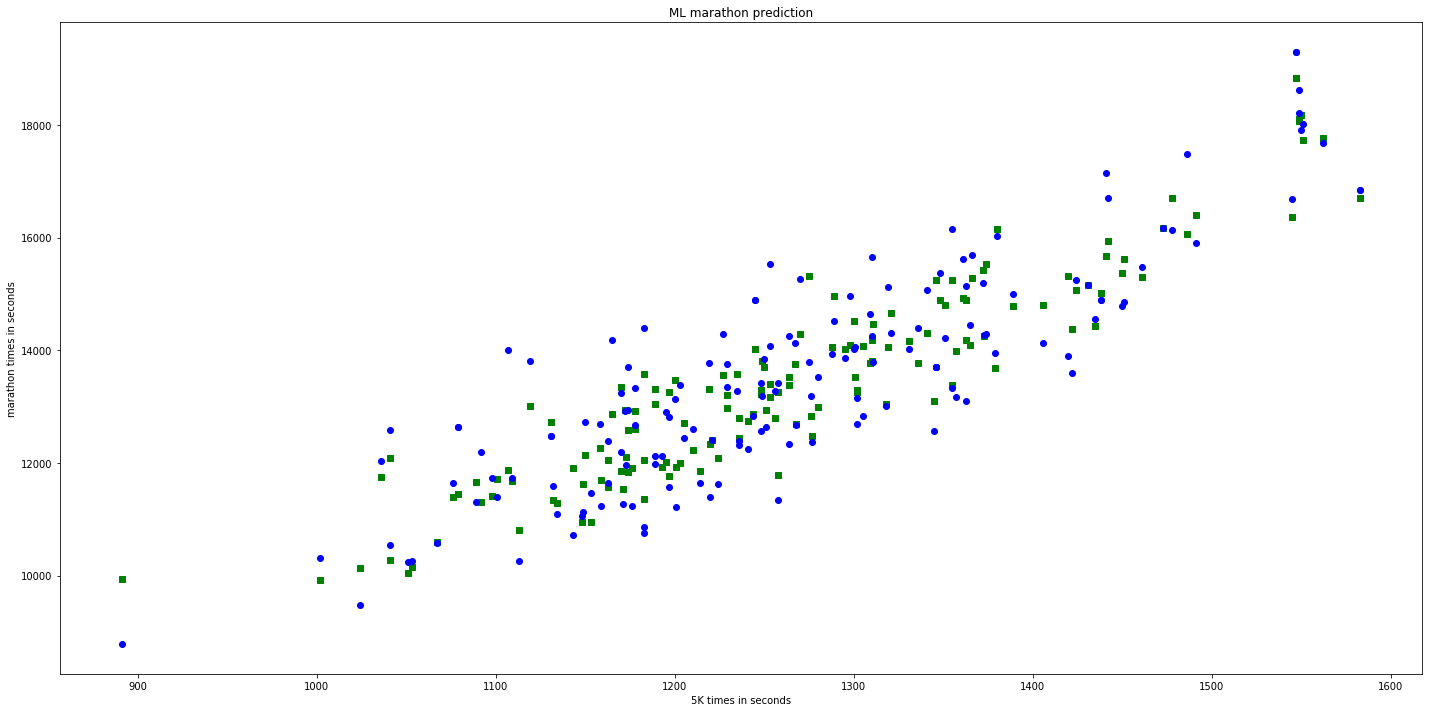

In [16]:
plt.figure(figsize=(20,10))
plt.xlabel('5K times in seconds')
plt.ylabel('marathon times in seconds')
plt.title('ML marathon prediction')
plt.plot(X_test['marathon']['5K'], best_regs['marathon']['pred'], 'gs', X_test['marathon']['5K'], y_test['marathon'], 'bo')

plt.tight_layout()
plt.show()

In [17]:
# Personal Prediction back in 2009
#print best_regs['marathon']

# predict based on '5K','half','marathonTrainDis12', 'marathonTrainPaceSec12'

m_reg = best_regs['marathon']['5K|half|marathonTrainDis12|marathonTrainPaceSec12']['reg']
myDF = pd.DataFrame(
    [[timeToSeconds('23:03'),timeToSeconds('1:48:36'),70,520]], columns=(
        '5K','half','marathonTrainDis12', 'marathonTrainPaceSec12'))

my_predicted_marathon = m_reg.predict(myDF)

print '2009 - first marathon:'
print 'online calculator using 5K: ', secondsToTime(riegel(timeToSeconds('23:03')))
print 'online calculator using half: ', secondsToTime(riegel(timeToSeconds('1:48:36'), half_dis))
print 'ML Race Predictor: ', secondsToTime(my_predicted_marathon)
print 'What I actually ran: 3:54:34'

#predict my second marathon including the half
m_reg = best_regs['marathon']['5K|half|marathonTrainDis12|marathonTrainPaceSec12']['reg']
myDF = pd.DataFrame(
    [[timeToSeconds('20:51'),timeToSeconds('1:40:36'), 120, 510]], columns=(
        '5K', 'half', 'marathonTrainDis12', 'marathonTrainPaceSec12'))

my_predicted_marathon = m_reg.predict(myDF)
print '-------------------'
print '2010 - pr marathon:'
print 'online calculator using 5K: ', secondsToTime(riegel(timeToSeconds('20:51')))
print 'online calculator using half: ', secondsToTime(riegel(timeToSeconds('1:40:36'), half_dis))
print 'ML Race Predictor: ', secondsToTime(my_predicted_marathon)
print 'What I actually ran: 3:37:07'


2009 - first marathon:
online calculator using 5K:  3:41:04
online calculator using half:  3:46:25
ML Race Predictor:  4:05:40
What I actually ran: 3:54:34
-------------------
2010 - pr marathon:
online calculator using 5K:  3:19:58
online calculator using half:  3:29:44
ML Race Predictor:  3:42:13
What I actually ran: 3:37:07


In [68]:
from sklearn.externals import joblib

joblib.dump(best_regs['marathon']['5K|half|marathonTrainDis3']['reg'], 'marathon.pkl') 

['marathon.pkl']